In [1]:
# pip install qiskit==0.31.0

In [2]:
from get_test_datasets import return_dataset
test_dataset = return_dataset()

/home/ritu/anaconda3/envs/dnn_for_qubit_mapping/lib/python3.8/site-packages/qiskit/version.py:20: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Generating QPE circuits


In [3]:
len(test_dataset)

400

In [4]:
import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from helper import *

Using TensorFlow backend.
ibmqfactory.load_account:WARNING:2023-11-27 11:00:18,393: Credentials are already in use. The existing account in the session will be replaced.


{'ibm_lagos': [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 5], [4, 5], [5, 3], [5, 4], [5, 6], [6, 5]], 'ibm_nairobi': [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 5], [4, 5], [5, 3], [5, 4], [5, 6], [6, 5]], 'ibm_perth': [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 5], [4, 5], [5, 3], [5, 4], [5, 6], [6, 5]]}


In [5]:
mlp_edge_feature = tf.keras.models.load_model("models/mlp_edge_features.keras")
dnn = tf.keras.models.load_model("models/dnn.keras")
mlp = tf.keras.models.load_model("models/mlp.keras")

2023-11-27 11:00:21.664828: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-11-27 11:00:21.710942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-27 11:00:21.711287: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.595GHz coreCount: 128 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 938.86GiB/s
2023-11-27 11:00:21.711621: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2023-11-27 11:00:21.711752: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic lib

In [6]:
basis_gate_dict = {}
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends(simulator=False)
backends = ['ibm_lagos','ibm_perth','ibm_nairobi']
for backend_name in backends:
    backend = provider.get_backend(backend_name)
    basis_gats = backend.configuration().basis_gates
    basis_gate_dict[backend_name] = basis_gats


In [7]:
def get_transpiled_circ_results(qc, backend, initial_layout):
    basis_gats = basis_gate_dict[backend]
    pass_ = Unroller(basis_gats)
    pm = PassManager(pass_)
    backend = provider.get_backend(backend)
    
    tqc = transpile(qc, backend=backend,initial_layout=initial_layout, optimization_level=0,seed_transpiler=13)
    tqc = pm.run(tqc)
    gates = dict(tqc.count_ops())
    return gates['cx'], tqc.depth()


In [46]:
SS = StandardScaler()
num_qubits = 7
count_or = 0
count_nr = 0
count_mlp = 0
count_mlp_edge = 0
original_depth, original_CNOT = [],[]
mlp_edge_depth, mlp_edge_CNOT = [],[]
dnn_without_ro_depth,dnn_without_ro_CNOT = [],[] 
dnn_with_ro_depth,dnn_with_ro_CNOT = [],[] 
mlp_depth, mlp_CNOT = [],[]

dnn_time = []
mlp_time = []
mlp_edge_time = []
sabre_time,na_time,dense_time = [],[],[]
for qc_i in tqdm(range(len(test_dataset[-5:]))):
    qc = test_dataset[qc_i]
    data = datetime.today() - timedelta(days=random.randint(1,150))
    backends = ['ibm_lagos','ibm_perth','ibm_nairobi']
    backend = backends[np.random.randint(0,3)]
    l = add_line(qc,backend, optimization_level=3, refresh=True, show= False, datatime=data)
    
    d={}
    for i in range(len(l[0])):
        d[str(l[0][i])] = l[1][i]
    df = pd.DataFrame(d, index=[0])
    df = clear_dataset(df, 7)
    last_num_qubits = len(df.columns)-num_qubits
    labels = ((df.iloc[:, last_num_qubits:].values)[0]).tolist()
    
#     time_taken_to_get_df = get_df_time(qc,backend,data)
#     print("Preprocess time:",time_taken_to_get_df)
    time_taken_to_get_df = 0
    
    start = time.time()
    x = SS.fit_transform(df.iloc[:, 2:last_num_qubits].values)
    predicted = dnn.predict(x)
    pred_or = np.array(pred_layout(predicted, num_qubits))[0].tolist()
    pred_nr = np.array(pred_layout_diff_elem(predicted,num_qubits))[0].tolist()
    end = time.time()
    dnn_time.append(time_taken_to_get_df + (end-start))
    
    print(pred_or, pred_nr, labels)
    if(pred_or == labels):
        count_or = count_or + 1
    if(pred_nr == labels):
        count_nr = count_nr + 1
    
    start = time.time()
    mlp_pred = get_labels(np.reshape(mlp.predict(x),(7,7)))
    end = time.time()
    mlp_time.append(time_taken_to_get_df + (end-start))
    print(mlp_pred)
    if mlp_pred == labels:
        count_mlp = count_mlp + 1
        
    start = time.time()
    x = SS.fit_transform(get_graph_features(df))
    mlp_edges_pred = get_labels(np.reshape(mlp_edge_feature.predict(x),(7,7)))
    end = time.time()
    mlp_edge_time.append(time_taken_to_get_df + (end-start))
    print(mlp_edges_pred)
    if mlp_edges_pred == labels:
        count_mlp_edge = count_mlp_edge + 1
    
    
    # original circuit after unrolling
    cx, depth = get_transpiled_circ_results(qc, backend, initial_layout=labels)
    original_depth.append(depth)
    original_CNOT.append(cx)
    print(original_depth[-1],original_CNOT[-1])
    # NN with edge features
    if len(mlp_edges_pred) == len(set(mlp_edges_pred)):
        cx, depth = get_transpiled_circ_results(qc, backend, initial_layout=mlp_edges_pred)
        mlp_edge_depth.append(depth)
        mlp_edge_CNOT.append(cx)
    else:
        mlp_edge_depth.append(float('NaN'))
        mlp_edge_CNOT.append(float('NaN'))
        
    # NN without edge features
    if len(mlp_pred) == len(set(mlp_pred)):
        cx, depth = get_transpiled_circ_results(qc, backend, initial_layout=mlp_pred)
        mlp_depth.append(depth)
        mlp_CNOT.append(cx)
    else:
        mlp_depth.append(float('NaN'))
        mlp_CNOT.append(float('NaN'))
        
    # DNN without repair operator
    if len(pred_or) == len(set(pred_or)):
        cx, depth = get_transpiled_circ_results(qc, backend, initial_layout=pred_or)
        dnn_without_ro_depth.append(depth)
        dnn_without_ro_CNOT.append(cx)
    else:
        dnn_without_ro_depth.append(float("NaN"))
        dnn_without_ro_CNOT.append(float("NaN"))
        
    # DNN with RO
    cx, depth = get_transpiled_circ_results(qc, backend, initial_layout=pred_nr)
    dnn_with_ro_depth.append(depth)
    dnn_with_ro_CNOT.append(cx)
    
#     # execution times
    basis_gats = basis_gate_dict[backend]
    pass_ = Unroller(basis_gats)
    pm = PassManager(pass_)
    backend = provider.get_backend(backend)
    tqc = transpile(qc, backend=backend, optimization_level=0)
    tqc = pm.run(tqc)
    # noise adaptive time
    start = time.time()
    new_circ_lv3_na = transpile(tqc, backend=backend, optimization_level=0,layout_method='noise_adaptive')
    new_circ_lv3_na._layout.get_physical_bits()
    end = time.time()
    na_time.append(end-start)
    #  sabre time
    start = time.time()
    new_circ_lv3_sabre = transpile(tqc, backend=backend, optimization_level=0,layout_method='sabre',routing_method='sabre')
    new_circ_lv3_sabre._layout.get_physical_bits()
    end = time.time()
    sabre_time.append(end-start)
    # dense time
    start = time.time()
    new_circ_lv3_dense = transpile(tqc, backend=backend, optimization_level=0)
    new_circ_lv3_dense._layout.get_physical_bits()
    end = time.time()
    dense_time.append(end-start)
    

print("DNN accuracy without repair operator:", count_or/len(test_dataset))
print("DNN accuracy with repair operator:", count_nr/len(test_dataset))
print("MLP accuracy:", count_mlp/len(test_dataset))
print("MLP with edge features accuracy:", count_mlp_edge/len(test_dataset))

  0%|                                                                                                                                                            | 0/5 [00:00<?, ?it/s]

2023-10-09 12:15:08.683877
Backend topology: 2023-10-09 12:15:08.683877
Depth: [92, 92, 78, 78, 78, 78]
not na


,last_update_date,backend_name,N_qubtis,N_cx,cx_01,cx_02,cx_03,cx_04,cx_05,cx_06,...,T1_6,T2_6,readout_error_6,0,1,2,3,4,5,6
0,2023-10-09 11:39:03-07:00,ibm_perth,7,35,8,0,0,0,0,0,...,137.417059,216.542708,0.0112,0,1,2,3,4,5,6


[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



 20%|█████████████████████████████▌                                                                                                                      | 1/5 [00:02<00:11,  2.99s/it]

[2, 1, 0, 3, 4, 5, 6]
60 32
2023-07-07 12:15:11.675377
Backend topology: 2023-07-07 12:15:11.675377
Depth: [182, 182, 90, 90, 94, 94]
not na


,last_update_date,backend_name,N_qubtis,N_cx,cx_01,cx_02,cx_03,cx_04,cx_05,cx_06,...,T1_6,T2_6,readout_error_6,0,1,2,3,4,5,6
0,2023-07-07 10:42:22-07:00,ibm_lagos,7,44,0,0,0,0,0,0,...,181.749233,116.403708,0.0159,0,1,2,3,4,5,6


[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



 40%|███████████████████████████████████████████████████████████▏                                                                                        | 2/5 [00:07<00:11,  3.68s/it]

[2, 1, 0, 3, 4, 5, 6]
59 44
2023-08-27 12:15:15.839788
Backend topology: 2023-08-27 12:15:15.839788
Depth: [124, 124, 82, 82, 82, 82]
not na


,last_update_date,backend_name,N_qubtis,N_cx,cx_01,cx_02,cx_03,cx_04,cx_05,cx_06,...,T1_6,T2_6,readout_error_6,0,1,2,3,4,5,6
0,2023-08-27 12:10:31-07:00,ibm_perth,7,38,0,0,0,0,0,0,...,97.780636,288.278561,0.0097,0,1,2,3,4,5,6


[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 3/5 [00:15<00:11,  5.66s/it]

[2, 1, 0, 3, 4, 5, 6]
57 38
2023-11-03 12:15:23.854522
Backend topology: 2023-11-03 12:15:23.854522
Depth: [120, 120, 76, 76, 80, 80]
not na


,last_update_date,backend_name,N_qubtis,N_cx,cx_01,cx_02,cx_03,cx_04,cx_05,cx_06,...,T1_6,T2_6,readout_error_6,0,1,2,3,4,5,6
0,2023-11-03 10:10:06-07:00,ibm_perth,7,35,0,0,0,0,0,0,...,188.137705,259.427085,0.0131,0,1,2,3,4,5,6


[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 4/5 [00:16<00:04,  4.13s/it]

[2, 1, 0, 3, 4, 5, 6]
56 29
2023-09-12 12:15:25.646809
Backend topology: 2023-09-12 12:15:25.646809
Depth: [110, 110, 80, 80, 80, 80]
not na


,last_update_date,backend_name,N_qubtis,N_cx,cx_01,cx_02,cx_03,cx_04,cx_05,cx_06,...,T1_6,T2_6,readout_error_6,0,1,2,3,4,5,6
0,2023-09-12 11:00:34-07:00,ibm_perth,7,32,4,0,0,0,0,0,...,248.836281,213.623966,0.0129,0,1,2,3,4,5,6


[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.76s/it]

[2, 1, 0, 3, 4, 5, 6]
60 32
DNN accuracy without repair operator: 0.0
DNN accuracy with repair operator: 0.0
MLP accuracy: 0.0
MLP with edge features accuracy: 0.0


In [20]:
df = pd.DataFrame()
df["Label Depth"] = original_depth
df["Label CNOTs"] = original_CNOT

df["NN without edge features Depth"] = mlp_depth
df["NN without edge features CNOTs"] = mlp_CNOT

df["NN with edge features Depth"] = mlp_edge_depth
df["NN with edge features CNOTs"] = mlp_edge_CNOT

df["DNN without repair Depth"] = dnn_without_ro_depth
df["DNN without repair CNOTs"] = dnn_without_ro_CNOT

df["DNN with repair Depth"] = dnn_with_ro_depth
df["DNN with repair CNOTs"] = dnn_with_ro_CNOT

df["DNN Mapping time"] = dnn_time
df["NN without edge features Mapping time"] = mlp_time
df["NN with edge features Mapping time"] = mlp_edge_time
df["SABRE mapping Mapping time"] = sabre_time
df["Noise Adaptive Mapping time"] = na_time
df["Dense Mapping time"] = dense_time

In [21]:
df

,Label Depth,Label CNOTs,NN without edge features Depth,NN without edge features CNOTs,NN with edge features Depth,NN with edge features CNOTs,DNN without repair Depth,DNN without repair CNOTs,DNN with repair Depth,DNN with repair CNOTs,DNN Mapping time,NN without edge features Mapping time,NN with edge features Mapping time,SABRE mapping Mapping time,Noise Adaptive Mapping time,Dense Mapping time
0,60,32,NaN,NaN,62,35,62,35,62,35,0.010940,0.008420,0.013839,0.011827,0.011510,0.002655
1,59,44,NaN,NaN,59,44,59,44,59,44,0.010616,0.008597,0.012853,0.014319,0.014587,0.002804
2,57,38,NaN,NaN,57,38,57,38,57,38,0.011061,0.008651,0.012619,0.009130,0.015255,0.002752
3,66,44,NaN,NaN,56,29,56,29,56,29,0.010974,0.008689,0.013744,0.012737,0.011660,0.002606
4,56,29,NaN,NaN,62,35,62,35,62,35,0.010890,0.008564,0.013134,0.008358,0.002935,0.002746


In [ ]:
import itertools
layouts = list(itertools.permutations([0,1,2,3,4,5,6]))
qc = test_dataset[-8]
basis_gats = basis_gate_dict['ibm_nairobi']
pass_ = Unroller(basis_gats)
pm = PassManager(pass_)
backend = provider.get_backend('ibm_nairobi')
for l in layouts[:20]:
    tqc = transpile(qc, backend=backend,initial_layout=list(l), optimization_level=0)
    tqc = pm.run(tqc)
    
    print(l,tqc.depth(),dict(tqc.count_ops())['cx'])

## Depth vs. Mapping time

In [ ]:
from qiskit.circuit.random import random_circuit


In [50]:
dnn_time = []
mlp_time = []
mlp_edge_time = []
sabre_time,na_time,dense_time = [],[],[]
for depth in tqdm(range(1,51)):
#     num_qubits = np.random.randint(5,8)
    qc = random_circuit(7, depth, measure=True)
    data = datetime.today() - timedelta(days=random.randint(1,150))
    backends = ['ibm_lagos','ibm_perth','ibm_nairobi']
    backend = backends[np.random.randint(0,3)]
    l = add_line(qc,backend, optimization_level=3, refresh=True, show= False, datatime=data)
    
    d={}
    for i in range(len(l[0])):
        d[str(l[0][i])] = l[1][i]
    df = pd.DataFrame(d, index=[0])
    df = clear_dataset(df, 7)
    last_num_qubits = len(df.columns)-num_qubits
    labels = ((df.iloc[:, last_num_qubits:].values)[0]).tolist()
    
#     time_taken_to_get_df = get_df_time(qc,backend,data)
#     print("Preprocess time:",time_taken_to_get_df)
    time_taken_to_get_df = 0
    
    start = time.time()
    
    x = SS.fit_transform(df.iloc[:, 2:last_num_qubits].values)
    predicted = dnn.predict(x)
    pred_or = np.array(pred_layout(predicted, num_qubits))[0].tolist()
    pred_nr = np.array(pred_layout_diff_elem(predicted,num_qubits))[0].tolist()
    end = time.time()
    dnn_time.append(time_taken_to_get_df + (end-start))
    
    print(pred_or, pred_nr, labels)
    if(pred_or == labels):
        count_or = count_or + 1
    if(pred_nr == labels):
        count_nr = count_nr + 1
    
    start = time.time()
    mlp_pred = get_labels(np.reshape(mlp.predict(x),(7,7)))
    end = time.time()
    mlp_time.append(time_taken_to_get_df + (end-start))
    print(mlp_pred)
    if mlp_pred == labels:
        count_mlp = count_mlp + 1
        
    start = time.time()
    x = SS.fit_transform(get_graph_features(df))
    mlp_edges_pred = get_labels(np.reshape(mlp_edge_feature.predict(x),(7,7)))
    end = time.time()
    mlp_edge_time.append(time_taken_to_get_df + (end-start))
    print(mlp_edge_time)
    
#     # execution times
    basis_gats = basis_gate_dict[backend]
    pass_ = Unroller(basis_gats)
    pm = PassManager(pass_)
    backend = provider.get_backend(backend)
    tqc = transpile(qc, backend=backend, optimization_level=0)
    tqc = pm.run(tqc)
    # noise adaptive time
    start = time.time()
    new_circ_lv3_na = transpile(tqc, backend=backend, optimization_level=0,layout_method='noise_adaptive')
    new_circ_lv3_na._layout.get_physical_bits()
    end = time.time()
    na_time.append(end-start)
    # sabre time
    start = time.time()
    new_circ_lv3_sabre = transpile(tqc, backend=backend, optimization_level=0,layout_method='sabre',routing_method='sabre')
    new_circ_lv3_sabre._layout.get_physical_bits()
    end = time.time()
    sabre_time.append(end-start)
    # dense time
    start = time.time()
    new_circ_lv3_dense = transpile(tqc, backend=backend, optimization_level=0)
    new_circ_lv3_dense._layout.get_physical_bits()
    end = time.time()
    dense_time.append(end-start)
    
    

  0%|                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

2023-07-27 12:21:03.712325
Backend topology: 2023-07-27 12:21:03.712325
Depth: [264, 264, 102, 102, 102, 102]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



  2%|██▉                                                                                                                                                | 1/50 [00:02<01:52,  2.30s/it]

[0.012806415557861328]
2023-11-19 12:21:06.011577
Backend topology: 2023-11-19 12:21:06.011577
Depth: [220, 220, 142, 142, 190, 190]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



  4%|█████▉                                                                                                                                             | 2/50 [00:04<01:49,  2.29s/it]

[0.012806415557861328, 0.014092683792114258]
2023-08-28 12:21:08.291822
Backend topology: 2023-08-28 12:21:08.291822
Depth: [222, 222, 184, 184, 232, 232]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



  6%|████████▊                                                                                                                                          | 3/50 [00:06<01:46,  2.27s/it]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195]
2023-11-11 12:21:10.534628
Backend topology: 2023-11-11 12:21:10.534628
Depth: [156, 156, 154, 154, 156, 156]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



  8%|███████████▊                                                                                                                                       | 4/50 [00:09<01:42,  2.24s/it]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164]
2023-08-02 12:21:12.726940
Backend topology: 2023-08-02 12:21:12.726940
Depth: [610, 610, 300, 300, 300, 300]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



 10%|██████████████▋                                                                                                                                    | 5/50 [00:12<01:55,  2.58s/it]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055]
2023-09-16 12:21:15.903584
Backend topology: 2023-09-16 12:21:15.903584
Depth: [372, 372, 316, 316, 316, 316]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



 12%|█████████████████▋                                                                                                                                 | 6/50 [00:15<02:10,  2.97s/it]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727]
2023-10-13 12:21:19.640877
Backend topology: 2023-10-13 12:21:19.640877
Depth: [364, 364, 358, 358, 372, 372]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



 14%|████████████████████▌                                                                                                                              | 7/50 [00:19<02:12,  3.09s/it]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242]
2023-09-23 12:21:22.973886
Backend topology: 2023-09-23 12:21:22.973886
Depth: [472, 472, 474, 474, 474, 474]
na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [2, 0, 1, 3, 6, 5, 4]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 372.63it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734]



 16%|███████████████████████▌                                                                                                                           | 8/50 [00:24<02:32,  3.63s/it]

2023-11-10 12:21:27.765603
Backend topology: 2023-11-10 12:21:27.765603
Depth: [556, 556, 558, 558, 560, 560]
na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [4, 5, 6, 3, 2, 1, 0]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 569.49it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258]



 18%|██████████████████████████▍                                                                                                                        | 9/50 [00:27<02:27,  3.59s/it]

2023-07-03 12:21:31.253111
Backend topology: 2023-07-03 12:21:31.253111
Depth: [1166, 1166, 574, 574, 574, 574]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 354.73it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438]



 20%|█████████████████████████████▏                                                                                                                    | 10/50 [00:32<02:37,  3.94s/it]

2023-11-11 12:21:35.981025
Backend topology: 2023-11-11 12:21:35.981025
Depth: [704, 704, 704, 704, 706, 706]
na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [2, 0, 1, 3, 6, 5, 4]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 492.81it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336]



 22%|████████████████████████████████                                                                                                                  | 11/50 [00:37<02:43,  4.18s/it]

2023-07-07 12:21:40.716901
Backend topology: 2023-07-07 12:21:40.716901
Depth: [612, 612, 602, 602, 602, 602]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 578.29it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703]



 24%|███████████████████████████████████                                                                                                               | 12/50 [00:41<02:38,  4.17s/it]

2023-08-31 12:21:44.856842
Backend topology: 2023-08-31 12:21:44.856842
Depth: [1286, 1286, 744, 744, 744, 744]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 583.43it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867]



 26%|█████████████████████████████████████▉                                                                                                            | 13/50 [00:46<02:48,  4.54s/it]

2023-10-19 12:21:50.259225
Backend topology: 2023-10-19 12:21:50.259225
Depth: [964, 964, 876, 876, 896, 896]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 403.34it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789]



 28%|████████████████████████████████████████▉                                                                                                         | 14/50 [00:52<02:54,  4.86s/it]

2023-09-15 12:21:55.844044
Backend topology: 2023-09-15 12:21:55.844044
Depth: [1176, 1176, 1012, 1012, 1012, 1012]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 556.13it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602]



 30%|███████████████████████████████████████████▊                                                                                                      | 15/50 [00:58<03:02,  5.20s/it]

2023-11-23 12:22:01.843862
Backend topology: 2023-11-23 12:22:01.843862
Depth: [1526, 1526, 1154, 1154, 1154, 1154]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 594.26it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453]



 32%|██████████████████████████████████████████████▋                                                                                                   | 16/50 [01:13<04:37,  8.15s/it]

2023-10-15 12:22:16.844854
Backend topology: 2023-10-15 12:22:16.844854
Depth: [1812, 1812, 1032, 1032, 1032, 1032]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 560.29it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383]



 34%|█████████████████████████████████████████████████▋                                                                                                | 17/50 [01:20<04:24,  8.02s/it]

2023-10-02 12:22:24.553948
Backend topology: 2023-10-02 12:22:24.553948
Depth: [1146, 1146, 1136, 1136, 1138, 1138]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 384.02it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156]



 36%|████████████████████████████████████████████████████▌                                                                                             | 18/50 [01:28<04:14,  7.94s/it]

2023-07-17 12:22:32.319498
Backend topology: 2023-07-17 12:22:32.319498
Depth: [1184, 1184, 1130, 1130, 1130, 1130]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 595.78it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766]



 38%|███████████████████████████████████████████████████████▍                                                                                          | 19/50 [01:35<03:56,  7.64s/it]

2023-10-22 12:22:39.260861
Backend topology: 2023-10-22 12:22:39.260861
Depth: [1136, 1136, 1140, 1140, 1138, 1138]
na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [4, 5, 6, 3, 2, 1, 0]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 554.00it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211]



 40%|██████████████████████████████████████████████████████████▍                                                                                       | 20/50 [01:43<03:56,  7.88s/it]

2023-07-08 12:22:47.689291
Backend topology: 2023-07-08 12:22:47.689291
Depth: [1358, 1358, 1348, 1348, 1348, 1348]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 392.47it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781]



 42%|█████████████████████████████████████████████████████████████▎                                                                                    | 21/50 [02:08<06:16, 13.00s/it]

2023-07-14 12:23:12.617511
Backend topology: 2023-07-14 12:23:12.617511
Depth: [1194, 1194, 1196, 1196, 1196, 1196]
na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [2, 0, 1, 3, 6, 5, 4]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 570.27it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547]



 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 22/50 [02:16<05:21, 11.49s/it]

2023-10-30 12:23:20.597368
Backend topology: 2023-10-30 12:23:20.597368
Depth: [2148, 2148, 1316, 1316, 1318, 1318]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 555.76it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293]



 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 23/50 [02:26<04:58, 11.05s/it]

2023-07-09 12:23:30.617746
Backend topology: 2023-07-09 12:23:30.617746
Depth: [2044, 2044, 1478, 1478, 1476, 1476]
SABRE
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 589.58it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625]



 48%|██████████████████████████████████████████████████████████████████████                                                                            | 24/50 [02:37<04:43, 10.90s/it]

2023-11-19 12:23:41.178692
Backend topology: 2023-11-19 12:23:41.178692
Depth: [1640, 1640, 1198, 1198, 1198, 1198]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 561.86it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164]



 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 25/50 [02:45<04:12, 10.11s/it]

2023-08-24 12:23:49.430349
Backend topology: 2023-08-24 12:23:49.430349
Depth: [1644, 1644, 1640, 1640, 1646, 1646]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 396.47it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332]



 52%|███████████████████████████████████████████████████████████████████████████▉                                                                      | 26/50 [02:56<04:04, 10.17s/it]

2023-08-22 12:23:59.744729
Backend topology: 2023-08-22 12:23:59.744729
Depth: [1554, 1554, 1554, 1554, 1554, 1554]
na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [2, 0, 1, 3, 6, 5, 4]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 559.91it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375]



 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 27/50 [03:06<03:55, 10.24s/it]

2023-08-09 12:24:10.138937
Backend topology: 2023-08-09 12:24:10.138937
Depth: [1668, 1668, 1676, 1676, 1670, 1670]
na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [2, 0, 1, 3, 6, 5, 4]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 601.16it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711]



 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                | 28/50 [03:17<03:52, 10.57s/it]

2023-06-30 12:24:21.480673
Backend topology: 2023-06-30 12:24:21.480673
Depth: [1350, 1350, 1344, 1344, 1360, 1360]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 525.80it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531]



 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                             | 29/50 [03:39<04:51, 13.87s/it]

2023-08-15 12:24:43.055905
Backend topology: 2023-08-15 12:24:43.055905
Depth: [1784, 1784, 1712, 1712, 1716, 1716]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 378.65it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242]



 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 30/50 [03:49<04:16, 12.81s/it]

2023-09-16 12:24:53.399236
Backend topology: 2023-09-16 12:24:53.399236
Depth: [2502, 2502, 1962, 1962, 1964, 1964]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 600.47it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242, 0.013813018798828125]



 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 31/50 [04:02<04:03, 12.83s/it]

2023-09-03 12:25:06.261147
Backend topology: 2023-09-03 12:25:06.261147
Depth: [1762, 1762, 1788, 1788, 1780, 1780]
na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [4, 5, 6, 3, 2, 1, 0]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 580.04it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242, 0.013813018798828125, 0.01271963119506836]



 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 32/50 [04:14<03:43, 12.44s/it]

2023-07-31 12:25:17.789462
Backend topology: 2023-07-31 12:25:17.789462
Depth: [2252, 2252, 2104, 2104, 2144, 2144]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 542.46it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242, 0.013813018798828125, 0.01271963119506836, 0.015584707260131836]



 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 33/50 [04:28<03:40, 12.98s/it]

2023-08-16 12:25:32.030423
Backend topology: 2023-08-16 12:25:32.030423
Depth: [2530, 2530, 2208, 2208, 2208, 2208]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 596.97it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242, 0.013813018798828125, 0.01271963119506836, 0.015584707260131836, 0.013130664825439453]



 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 34/50 [04:39<03:20, 12.53s/it]

2023-10-27 12:25:43.499177
Backend topology: 2023-10-27 12:25:43.499177
Depth: [1936, 1936, 1924, 1924, 1940, 1940]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 542.74it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242, 0.013813018798828125, 0.01271963119506836, 0.015584707260131836, 0.013130664825439453, 0.013388395309448242]



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 35/50 [04:51<03:03, 12.23s/it]

2023-11-02 12:25:55.034874
Backend topology: 2023-11-02 12:25:55.034874
Depth: [2044, 2044, 2032, 2032, 1998, 1998]
SABRE
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [6, 5, 4, 3, 0, 1, 2]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 322.66it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242, 0.013813018798828125, 0.01271963119506836, 0.015584707260131836, 0.013130664825439453, 0.013388395309448242, 0.014805793762207031]



 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 36/50 [05:11<03:23, 14.54s/it]

2023-10-01 12:26:14.958780
Backend topology: 2023-10-01 12:26:14.958780
Depth: [2056, 2056, 2064, 2064, 2080, 2080]
na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [4, 5, 6, 3, 2, 1, 0]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 548.49it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242, 0.013813018798828125, 0.01271963119506836, 0.015584707260131836, 0.013130664825439453, 0.013388395309448242, 0.014805793762207031, 0.01290440559387207]



 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 37/50 [05:23<03:00, 13.86s/it]

2023-08-02 12:26:27.225023
Backend topology: 2023-08-02 12:26:27.225023
Depth: [2072, 2072, 2058, 2058, 2056, 2056]
SABRE
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 575.43it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242, 0.013813018798828125, 0.01271963119506836, 0.015584707260131836, 0.013130664825439453, 0.013388395309448242, 0.014805793762207031, 0.01290440559387207, 0.012985706329345703]



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 38/50 [05:37<02:47, 13.94s/it]

2023-10-17 12:26:41.349553
Backend topology: 2023-10-17 12:26:41.349553
Depth: [2150, 2150, 2144, 2144, 2146, 2146]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 625.92it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242, 0.013813018798828125, 0.01271963119506836, 0.015584707260131836, 0.013130664825439453, 0.013388395309448242, 0.014805793762207031, 0.01290440559387207, 0.012985706329345703, 0.01289510726928711]



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 39/50 [05:52<02:36, 14.24s/it]

2023-08-12 12:26:56.285077
Backend topology: 2023-08-12 12:26:56.285077
Depth: [2172, 2172, 2170, 2170, 2172, 2172]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 571.98it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242, 0.013813018798828125, 0.01271963119506836, 0.015584707260131836, 0.013130664825439453, 0.013388395309448242, 0.014805793762207031, 0.01290440559387207, 0.012985706329345703, 0.01289510726928711, 0.012449502944946289]



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 40/50 [06:06<02:22, 14.22s/it]

2023-10-08 12:27:10.481723
Backend topology: 2023-10-08 12:27:10.481723
Depth: [3860, 3860, 2642, 2642, 2644, 2644]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 398.21it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242, 0.013813018798828125, 0.01271963119506836, 0.015584707260131836, 0.013130664825439453, 0.013388395309448242, 0.014805793762207031, 0.01290440559387207, 0.012985706329345703, 0.01289510726928711, 0.012449502944946289, 0.013762712478637695]



 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 41/50 [06:27<02:24, 16.11s/it]

2023-06-30 12:27:30.977635
Backend topology: 2023-06-30 12:27:30.977635
Depth: [2616, 2616, 2598, 2598, 2600, 2600]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 554.44it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242, 0.013813018798828125, 0.01271963119506836, 0.015584707260131836, 0.013130664825439453, 0.013388395309448242, 0.014805793762207031, 0.01290440559387207, 0.012985706329345703, 0.01289510726928711, 0.012449502944946289, 0.013762712478637695, 0.013209819793701172]



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 42/50 [06:45<02:12, 16.62s/it]

2023-07-10 12:27:48.813754
Backend topology: 2023-07-10 12:27:48.813754
Depth: [2594, 2594, 2608, 2608, 2612, 2612]
na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [4, 5, 6, 3, 2, 1, 0]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 566.11it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242, 0.013813018798828125, 0.01271963119506836, 0.015584707260131836, 0.013130664825439453, 0.013388395309448242, 0.014805793762207031, 0.01290440559387207, 0.012985706329345703, 0.01289510726928711, 0.012449502944946289, 0.013762712478637695, 0.013209819793701172, 0.011909961700439453]



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 43/50 [07:14<02:23, 20.45s/it]

2023-08-20 12:28:18.178587
Backend topology: 2023-08-20 12:28:18.178587
Depth: [2600, 2600, 2600, 2600, 2604, 2604]
na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [2, 0, 1, 3, 6, 5, 4]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 335.36it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242, 0.013813018798828125, 0.01271963119506836, 0.015584707260131836, 0.013130664825439453, 0.013388395309448242, 0.014805793762207031, 0.01290440559387207, 0.012985706329345703, 0.01289510726928711, 0.012449502944946289, 0.013762712478637695, 0.013209819793701172, 0.011909961700439453, 0.014327764511108398]



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 44/50 [07:32<01:58, 19.72s/it]

2023-10-13 12:28:36.215440
Backend topology: 2023-10-13 12:28:36.215440
Depth: [2690, 2690, 2694, 2694, 2694, 2694]
na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [4, 5, 6, 3, 2, 1, 0]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 554.07it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242, 0.013813018798828125, 0.01271963119506836, 0.015584707260131836, 0.013130664825439453, 0.013388395309448242, 0.014805793762207031, 0.01290440559387207, 0.012985706329345703, 0.01289510726928711, 0.012449502944946289, 0.013762712478637695, 0.013209819793701172, 0.011909961700439453, 0.014327764511108398, 0.012137651443481445]



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 45/50 [07:50<01:36, 19.32s/it]

2023-11-07 12:28:54.596040
Backend topology: 2023-11-07 12:28:54.596040
Depth: [2966, 2966, 3012, 3012, 2990, 2990]
na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [4, 5, 6, 3, 2, 1, 0]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 527.78it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242, 0.013813018798828125, 0.01271963119506836, 0.015584707260131836, 0.013130664825439453, 0.013388395309448242, 0.014805793762207031, 0.01290440559387207, 0.012985706329345703, 0.01289510726928711, 0.012449502944946289, 0.013762712478637695, 0.013209819793701172, 0.011909961700439453, 0.014327764511108398, 0.012137651443481445, 0.012117147445678


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 46/50 [08:11<01:18, 19.61s/it]

2023-08-16 12:29:14.893989
Backend topology: 2023-08-16 12:29:14.893989
Depth: [2942, 2942, 2946, 2946, 2938, 2938]
SABRE
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 6, 5, 4]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 546.20it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242, 0.013813018798828125, 0.01271963119506836, 0.015584707260131836, 0.013130664825439453, 0.013388395309448242, 0.014805793762207031, 0.01290440559387207, 0.012985706329345703, 0.01289510726928711, 0.012449502944946289, 0.013762712478637695, 0.013209819793701172, 0.011909961700439453, 0.014327764511108398, 0.012137651443481445, 0.012117147445678


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 47/50 [08:32<01:00, 20.06s/it]

2023-09-06 12:29:35.978925
Backend topology: 2023-09-06 12:29:35.978925
Depth: [2996, 2996, 2482, 2482, 2478, 2478]
SABRE
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [4, 5, 6, 3, 0, 1, 2]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 571.35it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242, 0.013813018798828125, 0.01271963119506836, 0.015584707260131836, 0.013130664825439453, 0.013388395309448242, 0.014805793762207031, 0.01290440559387207, 0.012985706329345703, 0.01289510726928711, 0.012449502944946289, 0.013762712478637695, 0.013209819793701172, 0.011909961700439453, 0.014327764511108398, 0.012137651443481445, 0.012117147445678


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 48/50 [08:54<00:41, 20.77s/it]

2023-10-08 12:29:58.410556
Backend topology: 2023-10-08 12:29:58.410556
Depth: [2786, 2786, 2780, 2780, 2800, 2800]
not na
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 4, 5, 6]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 532.75it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242, 0.013813018798828125, 0.01271963119506836, 0.015584707260131836, 0.013130664825439453, 0.013388395309448242, 0.014805793762207031, 0.01290440559387207, 0.012985706329345703, 0.01289510726928711, 0.012449502944946289, 0.013762712478637695, 0.013209819793701172, 0.011909961700439453, 0.014327764511108398, 0.012137651443481445, 0.012117147445678


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 49/50 [09:19<00:21, 21.97s/it]

2023-08-05 12:30:23.201652
Backend topology: 2023-08-05 12:30:23.201652
Depth: [3336, 3336, 3330, 3330, 3326, 3326]
SABRE
[2, 1, 0, 3, 4, 5, 6] [2, 1, 0, 3, 4, 5, 6] [0, 1, 2, 3, 6, 5, 4]
[6, 1, 4, 3, 4, 5, 6]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 310.97it/s]

[0.012806415557861328, 0.014092683792114258, 0.012465715408325195, 0.012949228286743164, 0.012993574142456055, 0.012790918350219727, 0.012472867965698242, 0.014516353607177734, 0.013238191604614258, 0.014684677124023438, 0.01348257064819336, 0.012863636016845703, 0.013819456100463867, 0.01368570327758789, 0.012771844863891602, 0.013649463653564453, 0.012921571731567383, 0.013665199279785156, 0.013269901275634766, 0.013047933578491211, 0.013363838195800781, 0.014853954315185547, 0.01282191276550293, 0.012760162353515625, 0.01376962661743164, 0.01449894905090332, 0.012477874755859375, 0.013124227523803711, 0.012715339660644531, 0.014731168746948242, 0.013813018798828125, 0.01271963119506836, 0.015584707260131836, 0.013130664825439453, 0.013388395309448242, 0.014805793762207031, 0.01290440559387207, 0.012985706329345703, 0.01289510726928711, 0.012449502944946289, 0.013762712478637695, 0.013209819793701172, 0.011909961700439453, 0.014327764511108398, 0.012137651443481445, 0.012117147445678


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [09:54<00:00, 11.88s/it]


In [57]:
df = pd.DataFrame()
df["DNN"] = dnn_time
df["NN without edge features"] = mlp_time
df["NN with edge features"] = mlp_edge_time
df["SABRE"] =  sabre_time
df["Noise Adaptive"] = na_time
df["Dense"] = dense_time
# df["Index"] = list(range(1,51))

In [58]:
import pandas as pd

import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

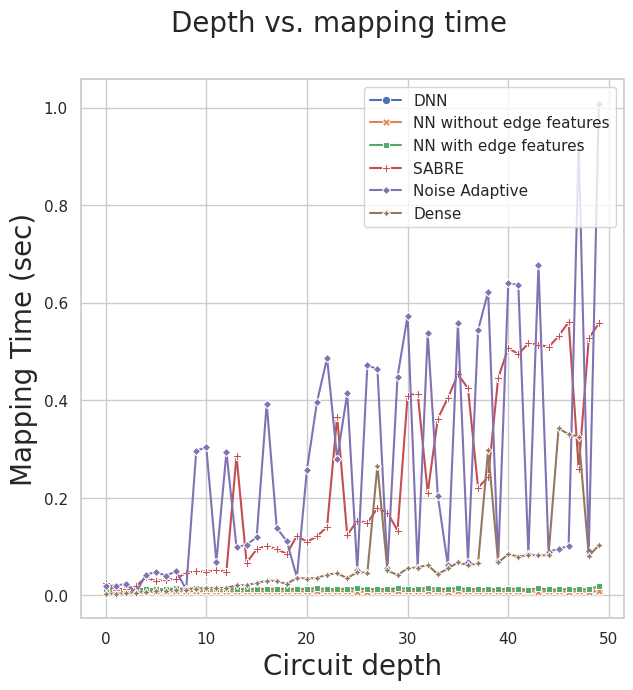

In [72]:
sns.set_theme(style="whitegrid")
a4_dims = (7,7)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df,markers=True, dashes=False)
fig.suptitle('Depth vs. mapping time ', fontsize=20)
plt.xlabel("Circuit depth", fontsize=20)
plt.ylabel("Mapping Time (sec)", fontsize=20)
plt.legend(loc='upper right')

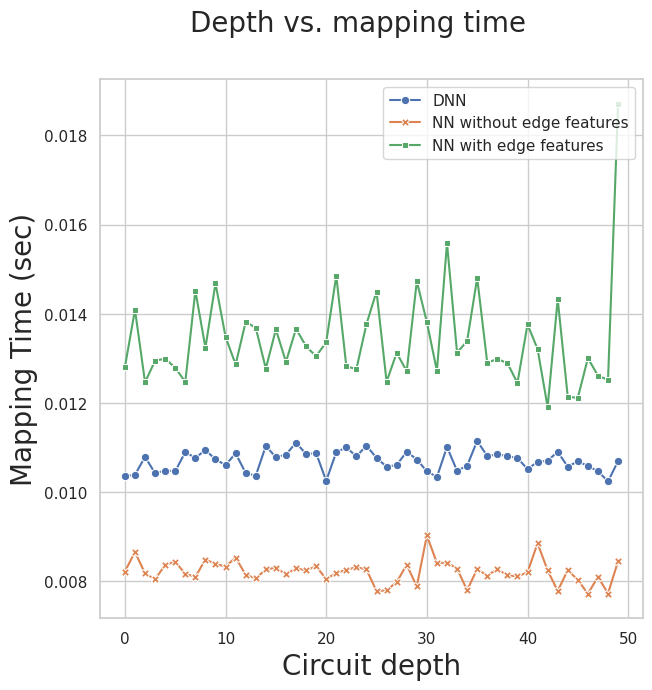

In [73]:
sns.set_theme(style="whitegrid")
a4_dims = (7,7)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df[["DNN","NN without edge features","NN with edge features"]],markers=True, dashes=False)
fig.suptitle('Depth vs. mapping time ', fontsize=20)
plt.xlabel("Circuit depth", fontsize=20)
plt.ylabel("Mapping Time (sec)", fontsize=20)
plt.legend(loc='upper right')

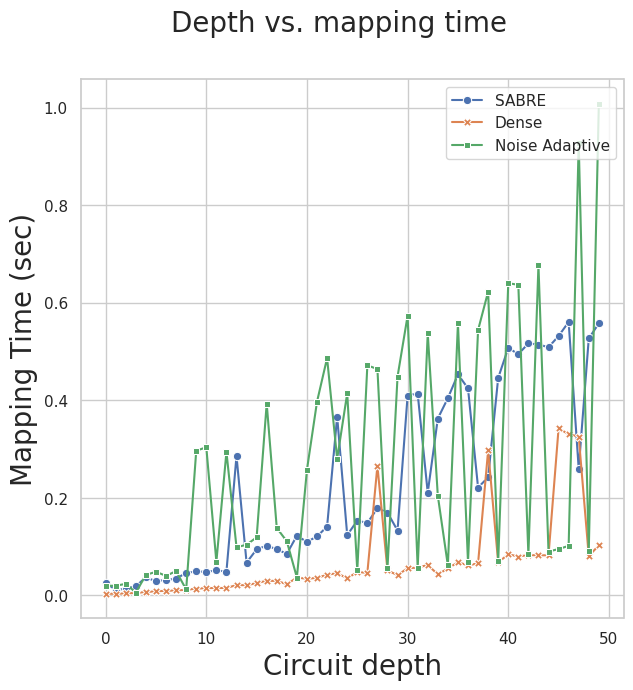

In [74]:
sns.set_theme(style="whitegrid")
a4_dims = (7,7)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df[["SABRE","Dense","Noise Adaptive"]],markers=True, dashes=False)
fig.suptitle('Depth vs. mapping time ', fontsize=20)
plt.xlabel("Circuit depth", fontsize=20)
plt.ylabel("Mapping Time (sec)", fontsize=20)
plt.legend(loc='upper right')